# Simulate and save firing rate for a cell

## 1. Input parameters

In [1]:
# Input parameters

# ------------------------------------------------------------------

# Cells  ID

# ------------------------------------------------------------------


cell_num = 3  # Numbers 1-5
cells_Name = [
    'bNAC219_L1_NGCDA_095997ce92',   # cell 1
    'bNAC219_L1_NGCDA_e7cec642c3',   # cell 2
    'bNAC219_L1_NGCDA_46b45974f4',   # cell 3
    'bNAC219_L1_NGCDA_b030a58a66',   # cell 4
    'bNAC219_L1_NGCDA_3d9c976fde'    # cell 5
]

cell_path = f'/home/lascon/Documents/241165/AberraEtAl2018/cells/L1_NGC-DA_bNAC219_{cell_num}'
cell_Name = cells_Name[cell_num-1]

cell_label = "_".join(cells_Name[0].split("_")[1:3])
cell_type = "_".join(cells_Name[0].split("_")[2:3])

# --------------------------------------------------------------

# Injected current

# --------------------------------------------------------------
# Choose one option a or b

import numpy as np
    # a) Simulate a current for each cell

#current_amps = np.loadtxt('current_amps.dat')    
    
    # b) Use the same current for each cell Ex. -0.015137, 0.0494352, 0.0535548, 0.0576744

current_amps = np.array([-0.015137, 0.0494352, 0.0535548, 0.0576744])  



# -----------------------------------------------------------

#  Compile .mod files

# -----------------------------------------------------------

# Config the cell path to compile .mod files
%cd "{cell_path}/mechanisms"
!nrnivmodl 

/home/lascon/Documents/241165/AberraEtAl2018/cells/L1_NGC-DA_bNAC219_3/mechanisms
/home/lascon/Documents/241165/AberraEtAl2018/cells/L1_NGC-DA_bNAC219_3/mechanisms
Mod files: "./CaDynamics_E2.mod" "./Ca_LVAst.mod" "./Ca.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./Nap_Et2.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./ProbAMPANMDA_EMS.mod" "./ProbGABAAB_EMS.mod" "./SK_E2.mod" "./SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


## 2. Cell and stimulus parameters

In [2]:
from neuron import h
from netpyne import specs, sim

h.chdir(cell_path)


#  load hoc
h.load_file('stdrun.hoc')
h.load_file('nrngui.hoc')
h.load_file('import3d.hoc')
h.load_file('morphology.hoc')
h.load_file('biophysics.hoc')
h.load_file('template.hoc')

# --------------------------------------------------------------

# Cell parameters

# --------------------------------------------------------------

def run_step_netpyne(step_amp, simLabel):
    sim.clearAll()  # important in loops

    netParams = specs.NetParams()
    simConfig = specs.SimConfig()

    # 1) Import the cell template -> it creates one rule com 'secs'
    netParams.importCellParams(
        label= cell_label, 
        conds={'cellType': cell_type},          # pop vai bater nessa cond
        fileName='template.hoc',
        cellName= cell_Name,
        cellArgs=[1],
        importSynMechs=False
    )

    # 2) Population  
    netParams.popParams['pop1'] = {
        'cellType': cell_type,
        'numCells': 1
    }

    # 3) IClamp
    netParams.stimSourceParams['iclamp'] = {
        'type': 'IClamp',
        'del': 100.0,
        'dur': 600.0,
        'amp': float(step_amp)
    }

    netParams.rotateCellsRandomly = [0, 6.2832]

    # 4) Config sim (first create, then discover the correct name of the soma)
    simConfig.duration = 800.0
    simConfig.dt = 0.025
    simConfig.recordStep = 0.025
    simConfig.filename = simLabel
    simConfig.saveJson = True
    simConfig.createNEURONObj = True
    simConfig.cache_efficient = True
    simConfig.checkErrors = False
    simConfig.analysis = {}
    # simConfig.saveLFPCells = True
    # simConfig.recordLFP = [[50, 100, 50], [50, 200, 50]]
    simConfig.recordLFP = [
        [50, 50,  0],
        [20, 40,  0],
        [0,  45, 55],
    ]


    # criate the network (no stimulation yet) just to inspect 
    sim.create(netParams=netParams, simConfig=simConfig)

    cell = sim.net.cells[0]
    secs = list(cell.secs.keys())
    print("Secs:", secs)

    # take soma automatically
    soma_sec = None
    for cand in ['soma_0', 'soma', 'soma[0]']: #try some usual patterns that soma appears
        if cand in cell.secs:
            soma_sec = cand
            break
    if soma_sec is None:
        raise RuntimeError(f"Soma not foubd. Secs available: {secs}")

    # 5) Now define the stim and record using the correct soma name
    netParams.stimTargetParams['iclamp->pop1'] = {
        'source': 'iclamp',
        'conds': {'pop': 'pop1'},
        'sec': soma_sec,
        'loc': 0.5
    }

    simConfig.recordCells = ['all'] 
    simConfig.recordTraces = {
        'V_soma': {'sec': soma_sec, 'loc': 0.5, 'var': 'v'},
        'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},
        'V_axon_1': {'sec':'axon_1', 'loc':0.5, 'var':'v'}, 
        'V_dend_0': {'sec':'dend_0', 'loc':0.5, 'var':'v'},                            
        'V_dend_1': {'sec':'dend_1', 'loc':0.5, 'var':'v'},            
        'V_dend_2': {'sec':'dend_2', 'loc':0.5, 'var':'v'},             
        'V_dend_3': {'sec':'dend_3', 'loc':0.5, 'var':'v'},
    }
    simConfig.recordStim = True
    simConfig.recordTime = True

    simConfig.analysis['plotTraces'] = {
        'include': ['pop1'], 
        'saveFig': False, 
        'overlay': True, 
        'oneFigPer': 'cell'}  # Plot recorded traces for this list of cells

    # simConfig.analysis['plotTraces'] = {'include': [0], 'saveFig': False}  # Plot recorded traces for this list of cells

    simConfig.analysis['plotConn'] = {'saveFig': False}    

    # 6) recreate from zero and run (to insure that stim+recordTraces work)
    sim.clearAll()
    sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

    sim.gatherData()                  			# gather spiking data and cell info from each node
    sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
    # sim.analysis.plotData() 


    #------------------------------------------------------------------------------
    # Saving
    #------------------------------------------------------------------------------
    simConfig.savePickle = False         	## Save pkl file
    simConfig.saveJson = False	           	## Save json file
    simConfig.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
    simConfig.backupCfgFile = None
    simConfig.gatherOnlySimData = False
    simConfig.saveCellSecs = True
    simConfig.saveCellConns = True
        
    
# -------------------------------------------------------

# Compute firing rate

# -------------------------------------------------------


import json
import numpy as np
import os

def compute_firing_rate(step_idx, thresh=-20.0):

    base = cell_path
    fname = os.path.join(base, f'step_{step_idx:02d}_data.json')

    with open(fname) as f:
        data = json.load(f)

    t = np.array(data['simData']['t'])
    # v = np.array(list(data['simData']['V_soma'].values())[0])

    # automatically find the soma voltage trace
    Vtrace = None
    for key, val in data['simData'].items():
        if key.lower().startswith('v'):   # it takes V_soma, V, v_soma_0, etc.
            if isinstance(val, dict) and len(val) > 0:
                Vtrace = np.array(next(iter(val.values())))
                break
            elif isinstance(val, list):
                Vtrace = np.array(val)
                break

    if Vtrace is None:
        raise RuntimeError("voltage no found in the trace, verify recordTraces in simConfig.")

    v = Vtrace

    

    # stim window (same as in protocol)
    stim_mask = (t > 100) & (t < 700)
    t_stim = t[stim_mask]
    v_stim = v[stim_mask]

    # detect matches in the limiar (spikes)
    crossings = (v_stim[:-1] < thresh) & (v_stim[1:] >= thresh)
    spike_times = t_stim[1:][crossings]

    # stim duration in seconds
    stim_dur = (700 - 100) / 1000.0  # 0.6 s

    firing_rate = len(spike_times) / stim_dur  # Hz

    return firing_rate, spike_times


	1 
	1 
	1 


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## 3. Run simulation per cell

Loaded current amps: [-0.015137   0.0494352  0.0535548  0.0576744]
Running step 0 | amp = -0.015137 nA
Starting to add synapses
Added inhibitory synapse 0 originating from cell 38 of m-type L1_HAC on basal section 46(0.899000) and dep 872.000000
Added inhibitory synapse 1 originating from cell 38 of m-type L1_HAC on basal section 7(0.504000) and dep 863.000000
Added inhibitory synapse 2 originating from cell 38 of m-type L1_HAC on basal section 7(0.449000) and dep 1041.000000
Added inhibitory synapse 3 originating from cell 38 of m-type L1_HAC on basal section 25(0.892000) and dep 553.000000
Added inhibitory synapse 4 originating from cell 38 of m-type L1_HAC on basal section 25(0.477000) and dep 937.000000
Added inhibitory synapse 5 originating from cell 38 of m-type L1_HAC on basal section 3(0.133000) and dep 306.000000
Added inhibitory synapse 6 originating from cell 38 of m-type L1_HAC on basal section 6(0.644000) and dep 847.000000
Added inhibitory synapse 7 originating from cell 



Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.12 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Secs: ['soma_0', 'dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29', 'dend_30', 'dend_31', 'dend_32', 'dend_33', 'dend_34', 'dend_35', 'dend_36', 'dend_37', 'dend_38', 'dend_39', 'dend_40', 'dend_41', 'dend_42', 'dend_43', 'dend_44', 'dend_45', 'dend_46', 'axon_0', 'axon_1']



Start time:  2026-01-26 18:21:32.434110




Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.05 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 7 traces of 7 types on node 0

Running simulation using NEURON for 800.0 ms...


  Done; run time = 31.77 s; real-time ratio: 0.03.

Gathering data...
  Done; gather time = 0.07 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 31.77 s
Saving output as step_00_data.json ... 
Finished saving!
  Done; saving time = 1.85 s.
Plotting recorded cell traces ... cell


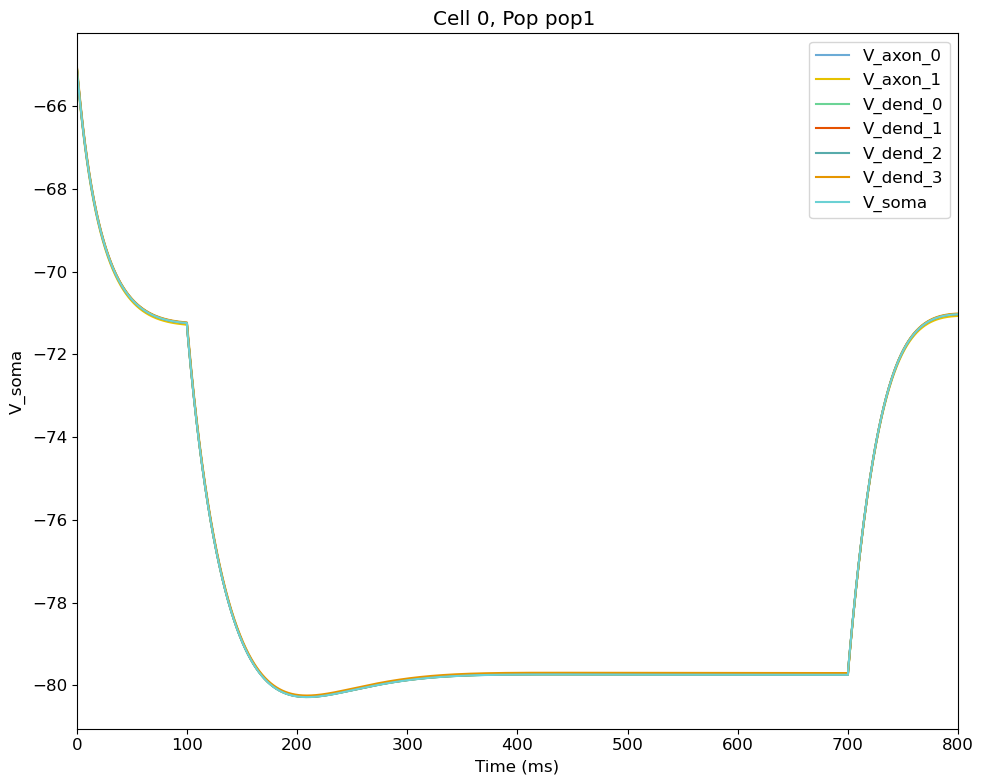

Plotting connectivity matrix...


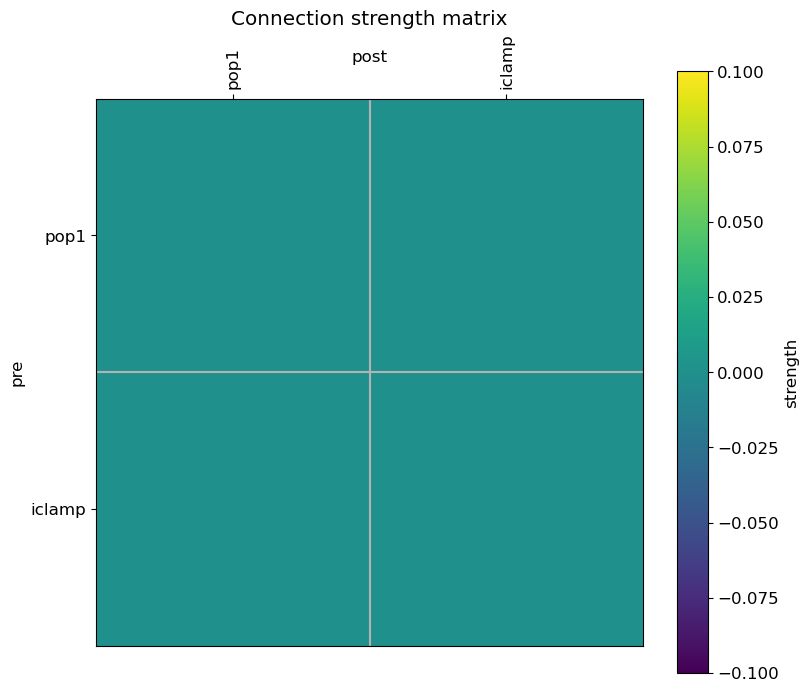

  Done; plotting time = 1.30 s

Total time = 35.14 s

Gathering data...
  Done; gather time = 0.05 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 31.77 s
Saving output as step_00_data.json ... 
Finished saving!
  Done; saving time = 1.24 s.
Running step 1 | amp = 0.0494352 nA
Starting to add synapses
Added inhibitory synapse 0 originating from cell 38 of m-type L1_HAC on basal section 46(0.899000) and dep 872.000000
Added inhibitory synapse 1 originating from cell 38 of m-type L1_HAC on basal section 7(0.504000) and dep 863.000000
Added inhibitory synapse 2 originating from cell 38 of m-type L1_HAC on basal section 7(0.449000) and dep 1041.000000
Added inhibitory synapse 3 originating from cell 38 of m-type L1_HAC on basal section 25(0.892000) and dep 553.000000
Added inhibitory synapse 4 originating from cell 38 of m-type L1_HAC on basal section 25(0.477000) and dep 937.000000
Added inhibitory synapse 5



Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.07 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Secs: ['soma_0', 'dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29', 'dend_30', 'dend_31', 'dend_32', 'dend_33', 'dend_34', 'dend_35', 'dend_36', 'dend_37', 'dend_38', 'dend_39', 'dend_40', 'dend_41', 'dend_42', 'dend_43', 'dend_44', 'dend_45', 'dend_46', 'axon_0', 'axon_1']



Start time:  2026-01-26 18:22:10.651798




Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.08 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 7 traces of 7 types on node 0

Running simulation using NEURON for 800.0 ms...


  Done; run time = 55.74 s; real-time ratio: 0.01.

Gathering data...
  Done; gather time = 0.03 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 55.74 s
Saving output as step_01_data.json ... 
Finished saving!
  Done; saving time = 1.51 s.
Plotting recorded cell traces ... cell


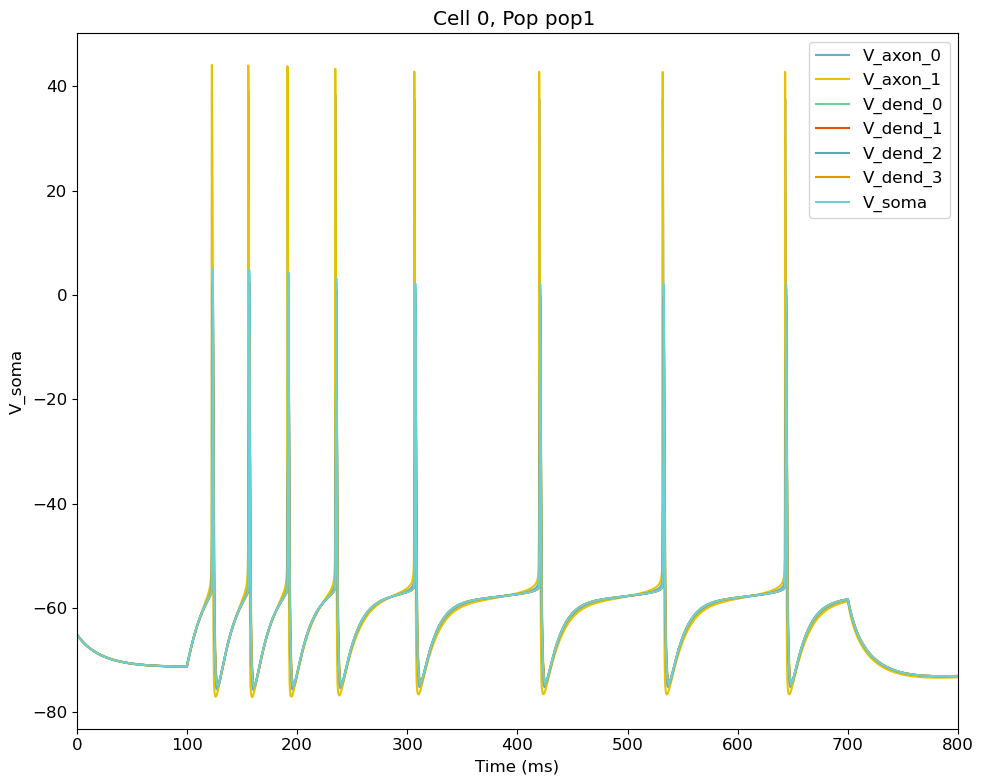

Plotting connectivity matrix...


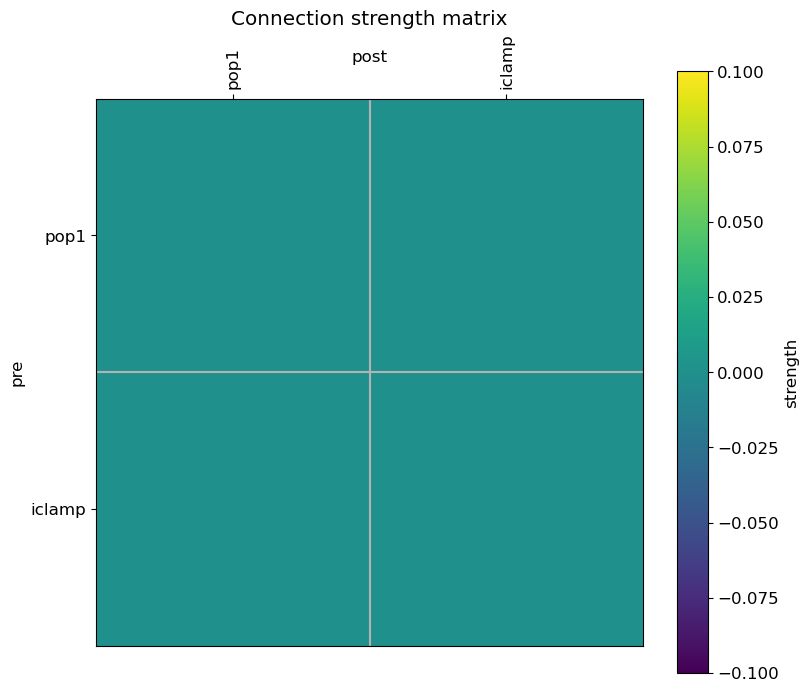

  Done; plotting time = 1.30 s

Total time = 58.77 s

Gathering data...
  Done; gather time = 0.07 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 55.74 s
Saving output as step_01_data.json ... 
Finished saving!
  Done; saving time = 1.50 s.
Running step 2 | amp = 0.0535548 nA
Starting to add synapses
Added inhibitory synapse 0 originating from cell 38 of m-type L1_HAC on basal section 46(0.899000) and dep 872.000000
Added inhibitory synapse 1 originating from cell 38 of m-type L1_HAC on basal section 7(0.504000) and dep 863.000000
Added inhibitory synapse 2 originating from cell 38 of m-type L1_HAC on basal section 7(0.449000) and dep 1041.000000
Added inhibitory synapse 3 originating from cell 38 of m-type L1_HAC on basal section 25(0.892000) and dep 553.000000
Added inhibitory synapse 4 originating from cell 38 of m-type L1_HAC on basal section 25(0.477000) and dep 937.000000
Added inhibitory synapse 5



Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.07 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Secs: ['soma_0', 'dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29', 'dend_30', 'dend_31', 'dend_32', 'dend_33', 'dend_34', 'dend_35', 'dend_36', 'dend_37', 'dend_38', 'dend_39', 'dend_40', 'dend_41', 'dend_42', 'dend_43', 'dend_44', 'dend_45', 'dend_46', 'axon_0', 'axon_1']



Start time:  2026-01-26 18:23:12.648570




Creating network of 1 cell populations on 1 hosts...: 100%|##########|

  Number of cells on node 0: 1 
  Done; cell creation time = 0.09 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 7 traces of 7 types on node 0

Running simulation using NEURON for 800.0 ms...


  Done; run time = 32.05 s; real-time ratio: 0.02.

Gathering data...
  Done; gather time = 0.03 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 32.05 s
Saving output as step_02_data.json ... 
Finished saving!
  Done; saving time = 1.10 s.
Plotting recorded cell traces ... cell


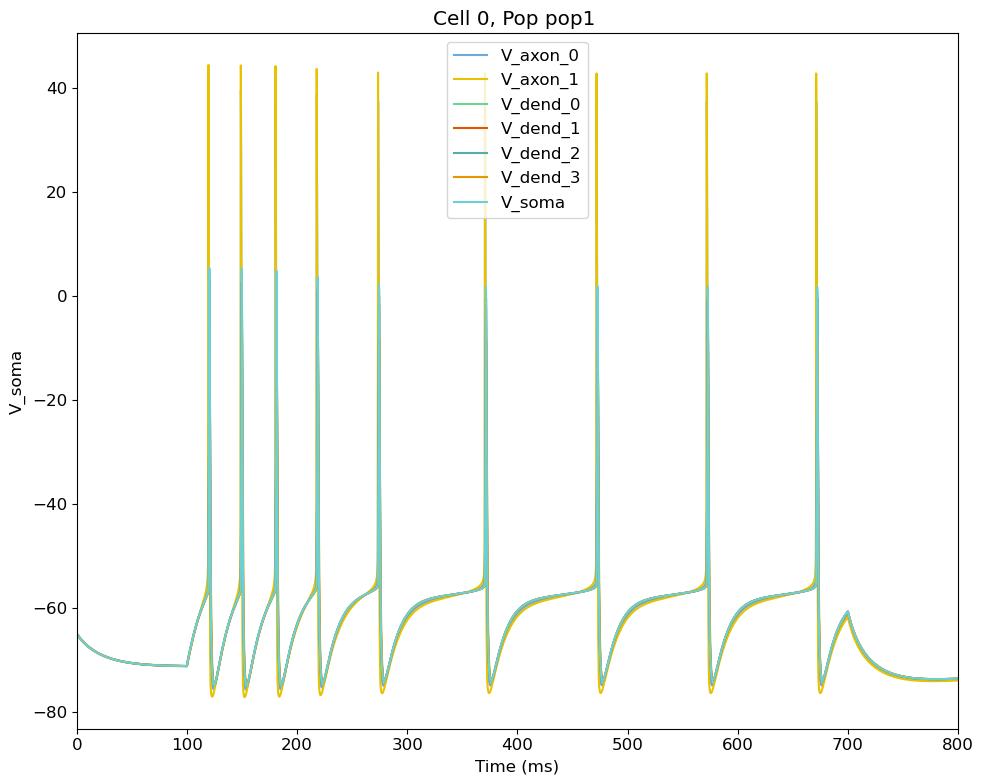

Plotting connectivity matrix...


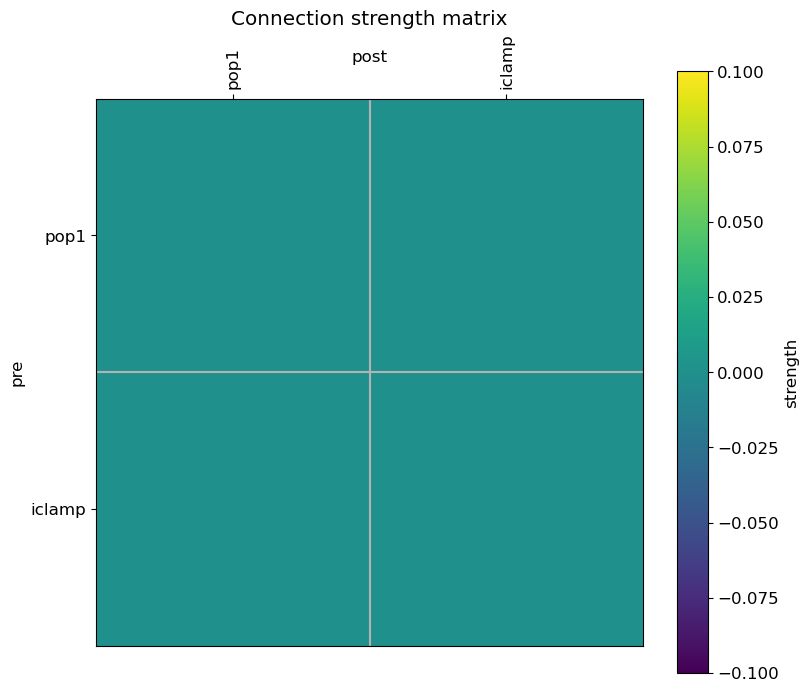

  Done; plotting time = 2.11 s

Total time = 35.47 s

Gathering data...
  Done; gather time = 0.04 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 32.05 s
Saving output as step_02_data.json ... 
Finished saving!
  Done; saving time = 1.04 s.
Running step 3 | amp = 0.0576744 nA
Starting to add synapses
Added inhibitory synapse 0 originating from cell 38 of m-type L1_HAC on basal section 46(0.899000) and dep 872.000000
Added inhibitory synapse 1 originating from cell 38 of m-type L1_HAC on basal section 7(0.504000) and dep 863.000000
Added inhibitory synapse 2 originating from cell 38 of m-type L1_HAC on basal section 7(0.449000) and dep 1041.000000
Added inhibitory synapse 3 originating from cell 38 of m-type L1_HAC on basal section 25(0.892000) and dep 553.000000
Added inhibitory synapse 4 originating from cell 38 of m-type L1_HAC on basal section 25(0.477000) and dep 937.000000
Added inhibitory synapse 5



Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 1 
  Done; cell creation time = 0.07 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Secs: ['soma_0', 'dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29', 'dend_30', 'dend_31', 'dend_32', 'dend_33', 'dend_34', 'dend_35', 'dend_36', 'dend_37', 'dend_38', 'dend_39', 'dend_40', 'dend_41', 'dend_42', 'dend_43', 'dend_44', 'dend_45', 'dend_46', 'axon_0', 'axon_1']

Start time:  2026-01-26 18:23:50.395735




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 1 
  Done; cell creation time = 0.05 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 7 traces of 7 types on node 0

Running simulation using NEURON for 800.0 ms...
  Done; run time = 23.78 s; real-time ratio: 0.03.

Gathering data...
  Done; gather time = 0.03 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 23.78 s
Saving output as step_03_data.json ... 
Finished saving!
  Done; saving time = 1.16 s.
Plotting recorded cell traces ... cell


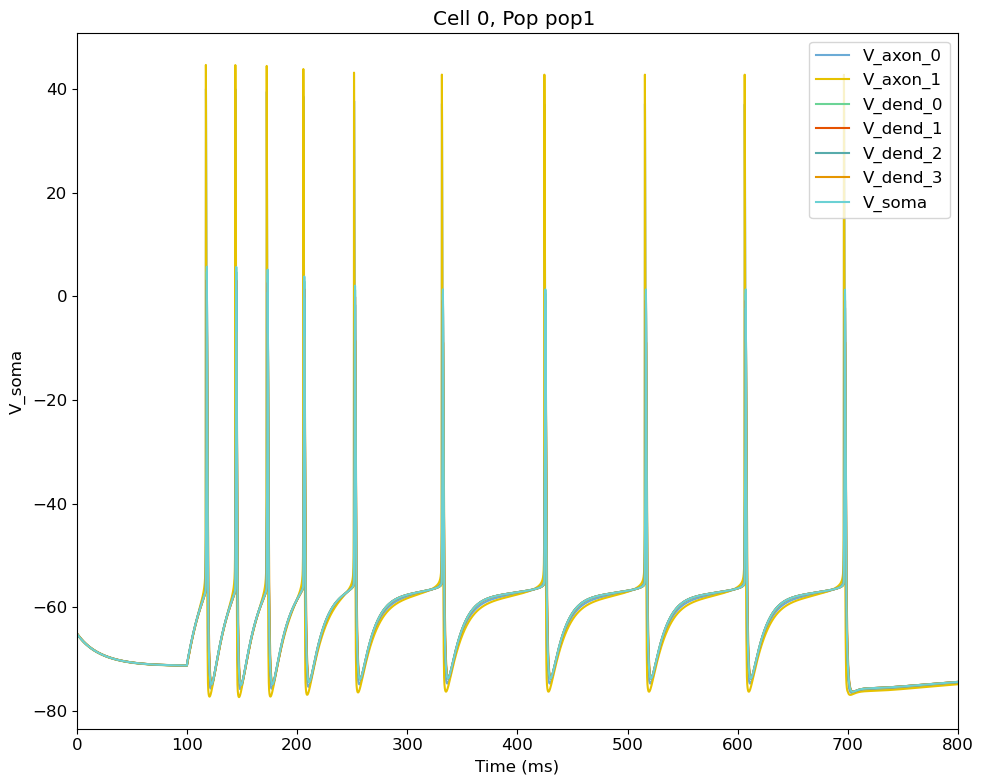

Plotting connectivity matrix...


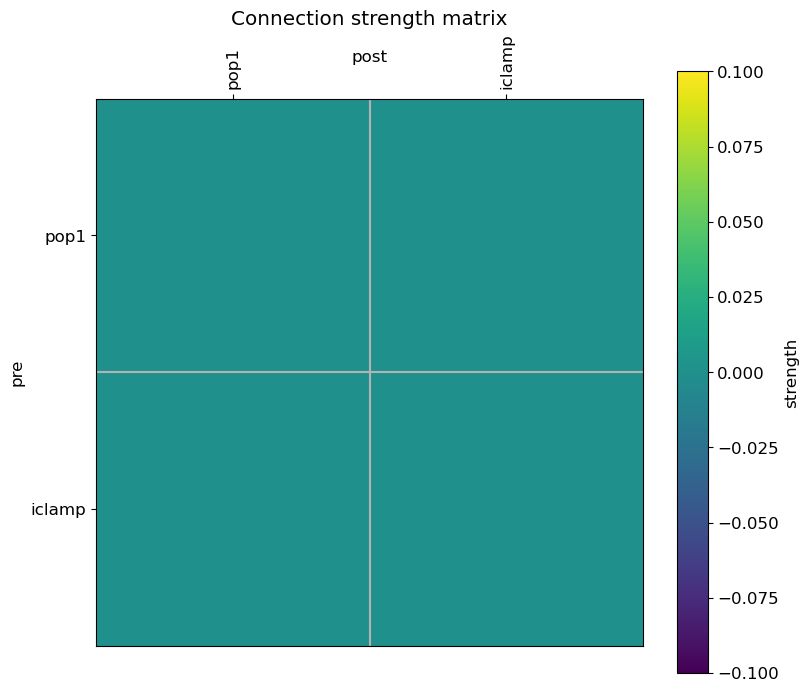

  Done; plotting time = 2.63 s

Total time = 27.75 s

Gathering data...
  Done; gather time = 0.04 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 0 (0.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 23.78 s
Saving output as step_03_data.json ... 
Finished saving!
  Done; saving time = 1.09 s.


In [3]:
# Add stimualition (intracelluraar)

print("Loaded current amps:", current_amps)

for i, amp in enumerate(current_amps):
    print(f'Running step {i} | amp = {amp} nA')
    run_step_netpyne(amp, simLabel=f'step_{i:02d}')


## 4. Append the values of firing rate, currents and spikes

In [4]:
import glob
import matplotlib.pyplot as plt

files = sorted(glob.glob("step_*.json"))

rates = []
all_spikes = []

for i, amp in enumerate(current_amps):
    fr, spikes = compute_firing_rate(i)
    rates.append(fr)
    all_spikes.append(spikes)
    print(f'I = {amp:.4f} nA → F = {fr:.2f} Hz ({len(spikes)} spikes)')

I = -0.0151 nA → F = 0.00 Hz (0 spikes)
I = 0.0494 nA → F = 13.33 Hz (8 spikes)
I = 0.0536 nA → F = 15.00 Hz (9 spikes)
I = 0.0577 nA → F = 16.67 Hz (10 spikes)


## 5. Save firing rate and spikes 

In [5]:
rates_file = os.path.join(cell_path, "rates2.dat")
spikes_file = os.path.join(cell_path, "spikes2.dat")


# ---- save rates.dat (amp, rate) ----
with open(rates_file, "w") as f:
    f.write("# idx\tamp_nA\trate_Hz\n")
    for i, (amp, fr) in enumerate(zip(current_amps, rates)):
        f.write(f"{i}\t{amp:.6f}\t{fr:.6f}\n")

# ---- save spikes.dat (one spike per line) ----
# Format: idx  amp_nA  spike_time
with open(spikes_file, "w") as f:
    f.write("# idx\tamp_nA\tspike_time\n")
    for i, (amp, spikes) in enumerate(zip(current_amps, all_spikes)):
        for t in spikes:
            f.write(f"{i}\t{amp:.6f}\t{float(t):.6f}\n")

## 6. Plot Firing rate vs Current

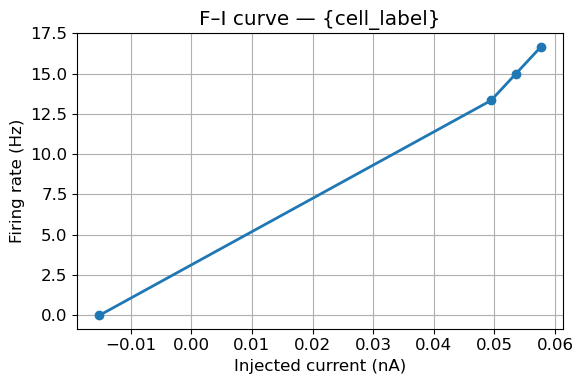

In [6]:
plt.figure(figsize=(6,4))

plt.plot(current_amps, rates, 'o-', lw=2)

plt.xlabel('Injected current (nA)')
plt.ylabel('Firing rate (Hz)')
plt.title('F–I curve — {cell_label}')

plt.grid(True)
plt.tight_layout()
plt.show()
